## Work
* 試比較 save_best_only 與否的差異
* 請僅存入將 save_weights_only 設定為 True,
* 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [17]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [18]:
train, test = keras.datasets.cifar10.load_data()

In [19]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [20]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [37]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(n_units))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(n_units))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [38]:
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(n_units))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(n_units))(x)
            x = BatchNormalization()(x)
    
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [58]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [59]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

In [60]:
results = {}
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

exp_name_tag = "save_best_only"
results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc,
                                 'loss_loadback': loss_loadback,
                                 'acc_loadback': acc_loadback}



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer512 (Dense)      (None, 512)               1573376   
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer256 (Dense)      (None, 256)               131328    
_________________________________________________________________
batch_normalization_44 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer128 (Dense)      (None, 128)               32896     
_________________________________________________________________
batch_normalization_45 (Batc (None, 128)               512       
__________

Epoch 50/50
10000/10000 [==============================] - 2s 175us/step


##load weights
This homework should be save the weight. But change the model and load the weight back for saving time.

In [61]:
from keras.models import model_from_json
from keras.models import Sequential
model_ckpt = ModelCheckpoint(filepath="./tmp_2.h5", 
                             monitor="val_loss", 
                             save_weights_only=True)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )
#model.load_weights("./tmp_2.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]


json_string = model.to_json()

#build the new model
#model = build_mlp2(input_shape=x_train.shape[1:])
#model.summary()
#model.add(Dense(10, name='new_dense'))

model = keras.models.Sequential()
model = model_from_json(json_string)
model.load_weights("./tmp_2.h5")
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

exp_name_tag = "save_weights_only"
results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc,
                                 'loss_loadback': loss_loadback,
                                 'acc_loadback': acc_loadback}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.0967 - acc: 0.6261 - val_loss: 1.4643 - val_acc: 0.4946
Epoch 2/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.0758 - acc: 0.6309 - val_loss: 1.4599 - val_acc: 0.4918
Epoch 3/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.0558 - acc: 0.6400 - val_loss: 1.4667 - val_acc: 0.4911
Epoch 4/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.0345 - acc: 0.6477 - val_loss: 1.4716 - val_acc: 0.4928
Epoch 5/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.0169 - acc: 0.6561 - val_loss: 1.4621 - val_acc: 0.4984
Epoch 6/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.9953 - acc: 0.6639 - val_loss: 1.4683 - val_acc: 0.4913
Epoch 7/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.9746 - acc: 0.6710 - val_loss: 1.4790 - val_ac

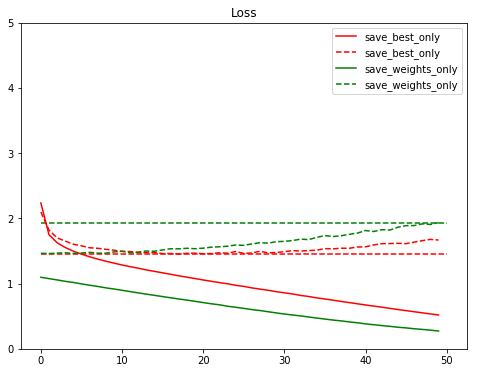

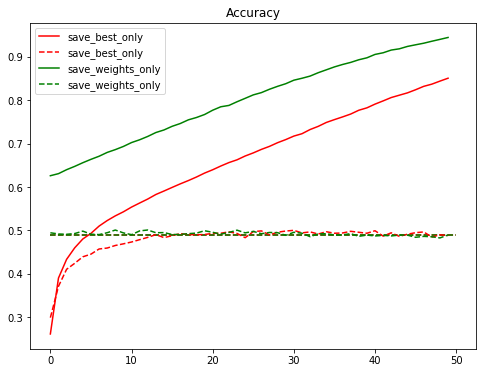

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","w","c"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%8])
    plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(results[cond]['train-loss']), colors=color_bar[i%8], linestyles='--')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%8])
    plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(results[cond]['train-loss']), colors=color_bar[i%8], linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test